In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

In [2]:
import importlib
import LearningCutsUtils.LearningCutsUtils
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils.LearningCutsUtils)
import LearningCutsUtils.LearningCutsUtils as LCU
from LearningCutsUtils.LearningCutsUtils import getBack, ListToGraph, OneToOneLinear, EfficiencyScanNetwork
from LearningCutsUtils.LearningCutsUtils import loss_fn
from LearningCutsUtils.LearningCutsUtils import effic_loss_fn

In [3]:
N=20000 # number of points
m=10 # dimensions

In [4]:
# array of means and widths for gaussians,
# indices are:
# - number of dimensions
# - signal (0) vs background (1)
# - mean (0) vs width (1)
np.random.seed(123)

# if we want more control over the function, for example
means_widths=[[[4,0.4],
               [-2,.10]],
              [[3,1.0],
               [-1,0.5]]]

means_widths=np.random.randn(m,2,2)               
width_scale_factor=2.
mean_scale_factor=2.

# now construct the training data.  after taking transpose, should be N rows by m columns.  
x_signal=np.array([means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
y_signal=np.ones(N)
x_backgr=np.array([means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
y_backgr=np.zeros(N)
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

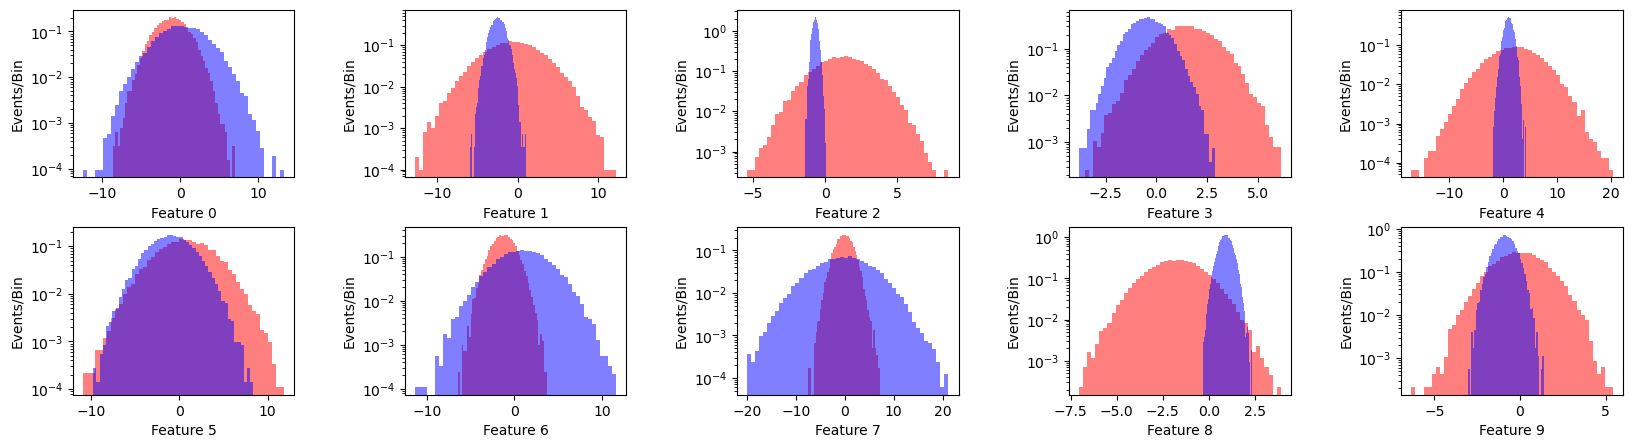

In [5]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [7]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [8]:
gt=1.
lt=-1.
cuts_gt_lt = [lt, gt, gt, gt, lt,
              gt, lt, lt, lt, gt]

In [9]:
targeteffics=[0.6,0.7,0.8,0.9]

# some hyperparameters
activation_input_scale_factor=8
learning_rate=0.5
batch_size=int(len(y_train)/1.) # only one batch
epochs=100
alpha=10.   # scaling factor to tune how important hitting the target signal efficiency is
beta=1.     # scaling factor to tune how important background rejection is
gamma=1e-3  # scaling factor for how aggressively to push the cuts to zero
epsilon=1e-2   # how much to penalize deviations

In [10]:
torch.manual_seed(123)

net = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt,activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
torch.save(net.state_dict(), 'net_learningbiases_effictarget_untrained.pth')

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

In [11]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningbiases_effictarget_untrained.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, epsilon,debug=debug)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")

torch.save(net.state_dict(), 'net_learningbiases_effictarget_trained.pth')

Completed epoch  0 in  0.8s, Train loss=2.2e+01, Test loss=2.2e+01
Completed epoch  1 in  0.8s, Train loss=2.2e+01, Test loss=2.1e+01
Completed epoch  2 in  0.6s, Train loss=2.1e+01, Test loss=2.0e+01
Completed epoch  3 in  0.8s, Train loss=2.0e+01, Test loss=1.7e+01
Completed epoch  4 in  0.7s, Train loss=1.7e+01, Test loss=1.2e+01
Completed epoch  5 in  0.9s, Train loss=1.2e+01, Test loss=6.4e+00
Completed epoch  6 in  0.9s, Train loss=6.5e+00, Test loss=3.1e+00
Completed epoch  7 in  0.7s, Train loss=3.1e+00, Test loss=1.6e+00
Completed epoch  8 in  0.7s, Train loss=1.6e+00, Test loss=1.0e+00
Completed epoch  9 in  0.7s, Train loss=1.0e+00, Test loss=7.3e-01
Completed epoch 10 in  0.7s, Train loss=7.1e-01, Test loss=5.6e-01
Completed epoch 11 in  0.8s, Train loss=5.5e-01, Test loss=4.6e-01
Completed epoch 12 in  0.7s, Train loss=4.4e-01, Test loss=3.8e-01
Completed epoch 13 in  0.8s, Train loss=3.7e-01, Test loss=3.3e-01
Completed epoch 14 in  0.7s, Train loss=3.2e-01, Test loss=2.9

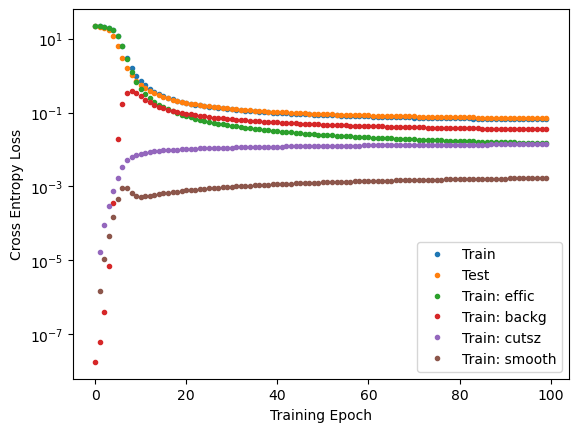

In [12]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

In [13]:
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor,y_test,net.nets[n],True)

Target efficiency: 60.0%
Signal Efficiency with net outputs: 62.7%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 70.0%
Signal Efficiency with net outputs: 71.6%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 80.0%
Signal Efficiency with net outputs: 80.9%
Background Efficiency with net outputs: 0.02509%
Target efficiency: 90.0%
Signal Efficiency with net outputs: 87.5%
Background Efficiency with net outputs: 0.45158%


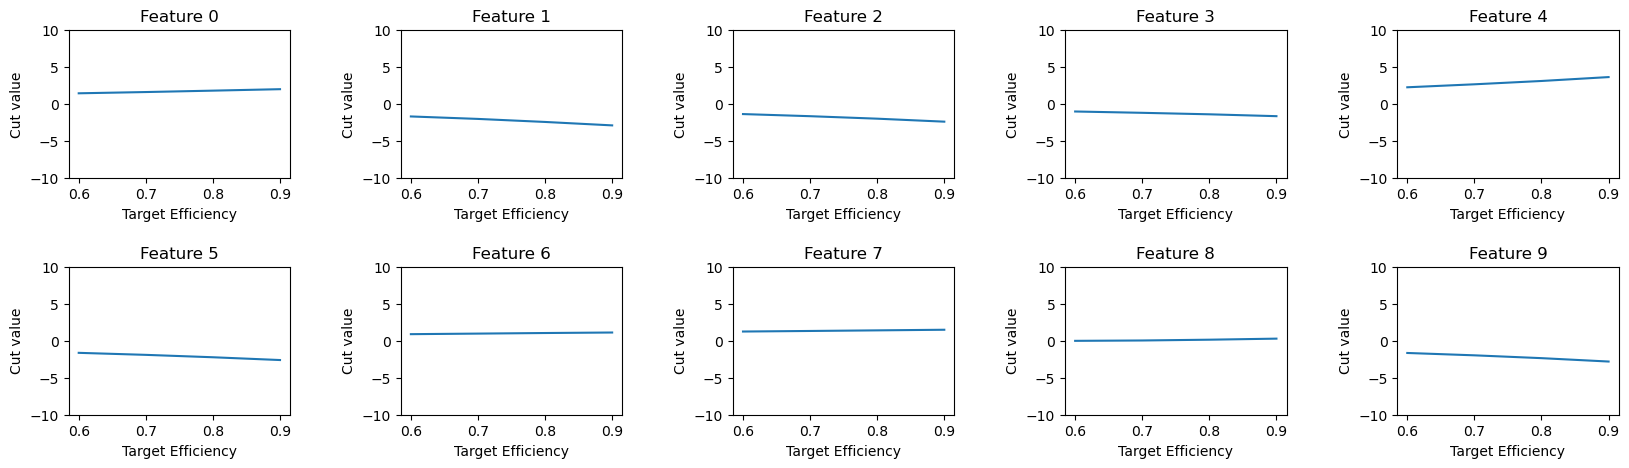

In [14]:
# Distributions of cuts
LearningCutsUtils.LearningCutsUtils.plotcuts(net)

Target efficiency: 60.0%
Cuts are: [ 1.4130617  -1.7137138  -1.3931215  -1.0447234   2.2254562  -1.6413809
  0.8806581   1.2363894  -0.02153778 -1.6598994 ]


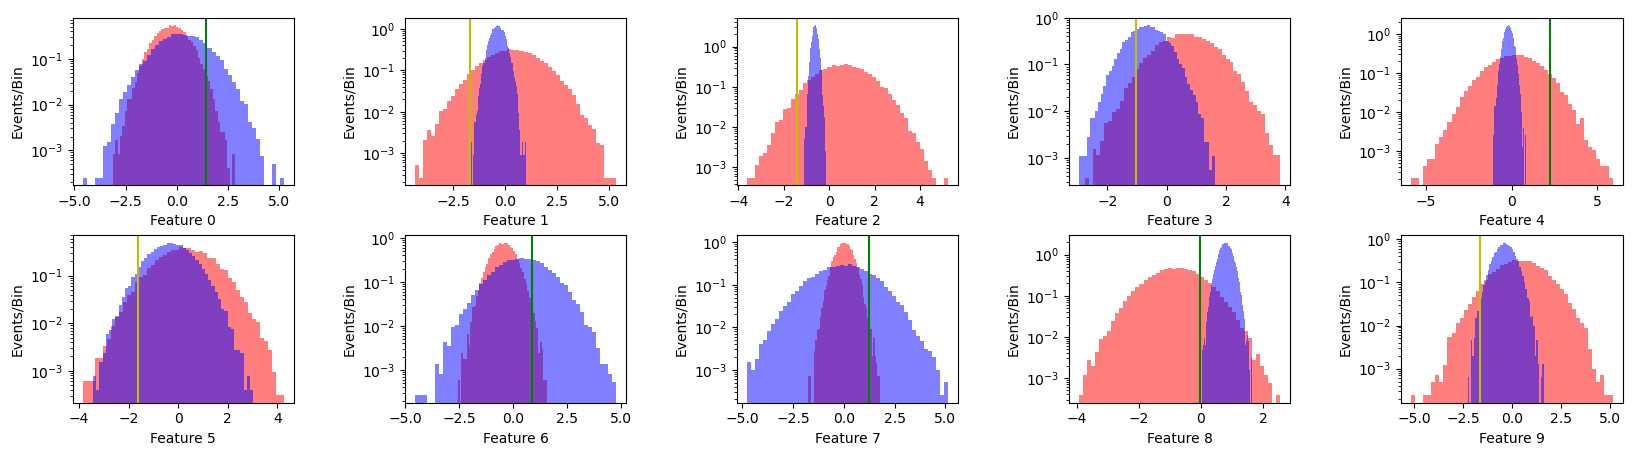

Target efficiency: 70.0%
Cuts are: [ 1.5824176  -2.0471294  -1.679456   -1.2228243   2.6283658  -1.9145893
  0.95685226  1.3127044   0.02743683 -1.9774793 ]


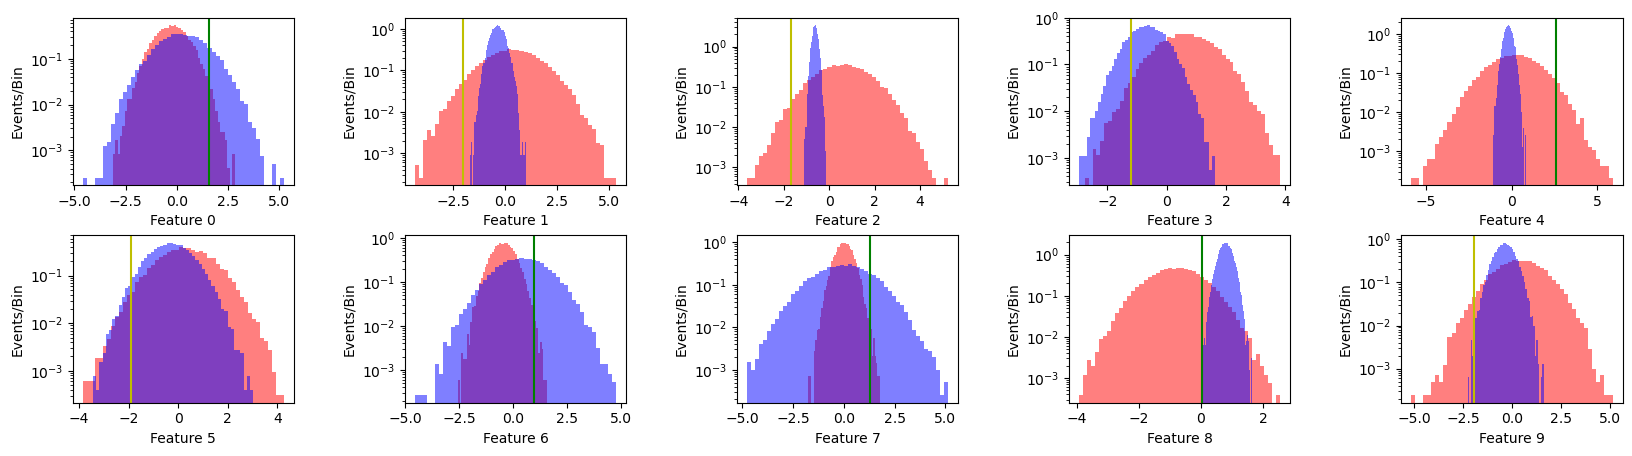

Target efficiency: 80.0%
Cuts are: [ 1.7720053  -2.4569726  -2.0145001  -1.4242893   3.0773416  -2.2380807
  1.0353423   1.3944197   0.13336864 -2.3592467 ]


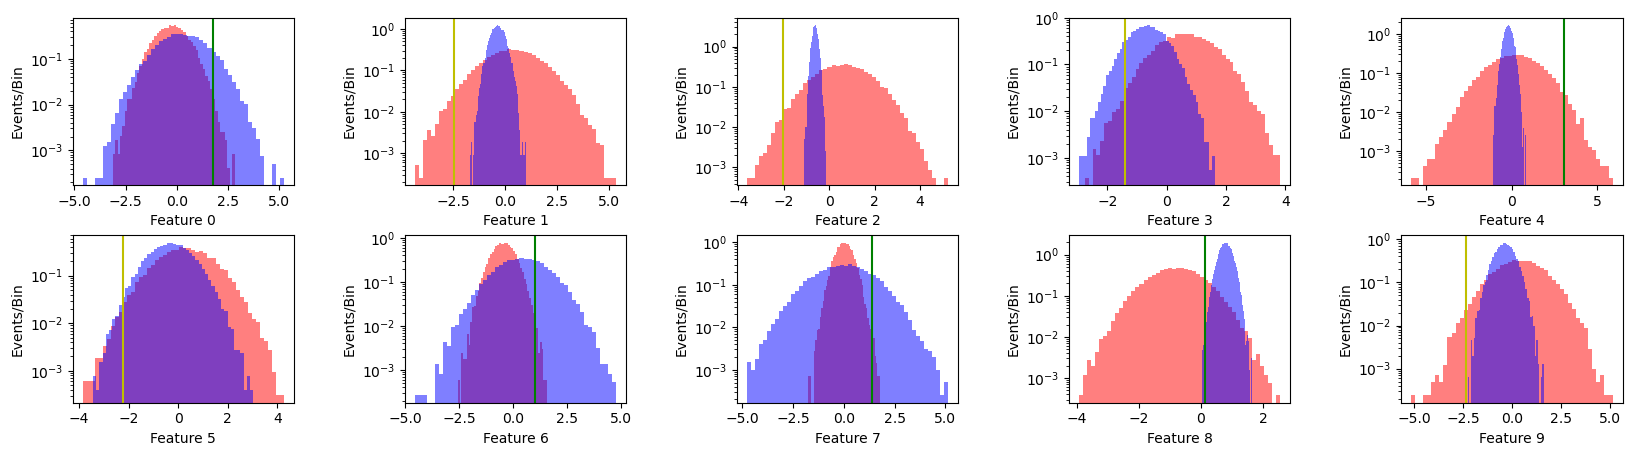

Target efficiency: 90.0%
Cuts are: [ 1.9687688  -2.920208   -2.4175847  -1.6764134   3.6034024  -2.6145103
  1.1040826   1.4767469   0.27612445 -2.8166692 ]


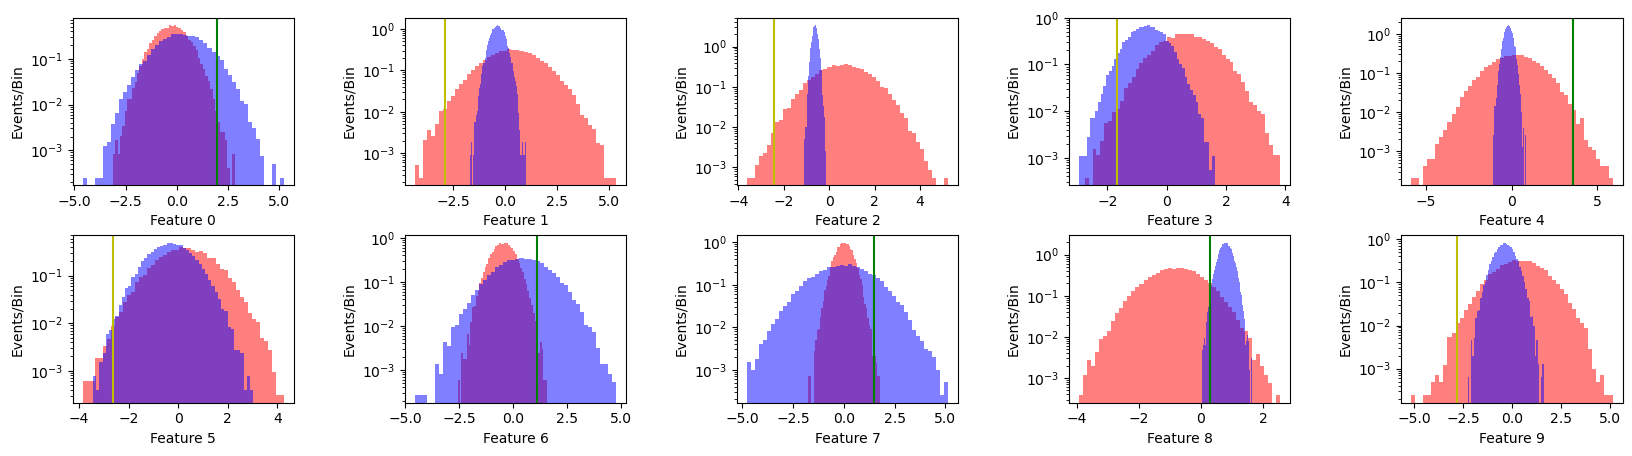

In [15]:
LearningCutsUtils.LearningCutsUtils.plotfeatures(net,x_signal,x_backgr,sc)

To do:
* Hyperparameter scan.
* Using real photon ID variables instead of dummies (Scott)
* documentation for LearningCutsUtils
* make separate files for classes, utility functions
* consider making some utility functions member functions of a network class
* __init__.py setup for LearningCutsUtils
* think more about how to smooth cuts vs pT, the current smoothing procedure is a three-point contraction that seems to be working, but maybe isn't optimal.